# Visión por Computadora

### Alan Reyes-Figueroa

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

from scipy.signal import correlate2d, convolve2d

from skimage import data
from skimage.feature import corner_harris, corner_subpix, corner_peaks
from skimage.transform import warp, AffineTransform
from skimage.draw import ellipse

from skimage.color import rgb2gray, gray2rgb
from skimage.transform import resize
from PIL import Image

from time import time 
import cv2

from matplotlib.patches import mlines

# Read Image

In [2]:
#I = data.camera()
#I = data.checkerboard()
I = data.binary_blobs()
#I = rgb2gray(I)

#r = 2.
#I = resize(I, (int(I.shape[0]*r), int(I.shape[1]*r)))
I = I.astype(np.uint8)
I.shape

(512, 512)

In [3]:
I[0,0]

0

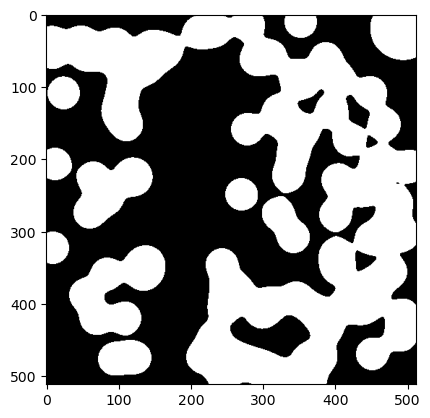

In [4]:
plt.figure()
plt.imshow(I, cmap='gray')
plt.show()

In [5]:
print(I.min(), I.max())

0 1


In [6]:
J = I - I.min()
J = J / J.max()

In [7]:
print(J.min(), J.max())

0.0 1.0


# Preparing Filters

In [8]:
# Sobel filters

hy = np.array([[-1,0,1], [-2,0,2], [-1,0,1]])
hx = (hy).T

print(hx.shape, hy.shape, '\n')
print(hx, '\n')
print(hy)

(3, 3) (3, 3) 

[[-1 -2 -1]
 [ 0  0  0]
 [ 1  2  1]] 

[[-1  0  1]
 [-2  0  2]
 [-1  0  1]]


In [9]:
# Gaussian kernel
g = np.array(([1/16, 2/16, 1/16], [2/16, 4/16, 2/16], [1/16, 2/16, 1/16.]))

print(g.shape, '\n')
print(g)

(3, 3) 

[[0.0625 0.125  0.0625]
 [0.125  0.25   0.125 ]
 [0.0625 0.125  0.0625]]


In [10]:
sz = 1
padJ = np.pad(J, pad_width=sz, mode='symmetric', reflect_type='even')

In [11]:
Gx = correlate2d(padJ, hx, mode='valid')
Gy = correlate2d(padJ, hy, mode='valid')

print(Gx.shape, Gy.shape)

(512, 512) (512, 512)


In [12]:
# Compute magnitude and angle
magnitude = np.sqrt(Gx**2 + Gy**2)
angle = (np.arctan2(-Gy, Gx) * (180/np.pi)) % 180.

angle = angle % 180.

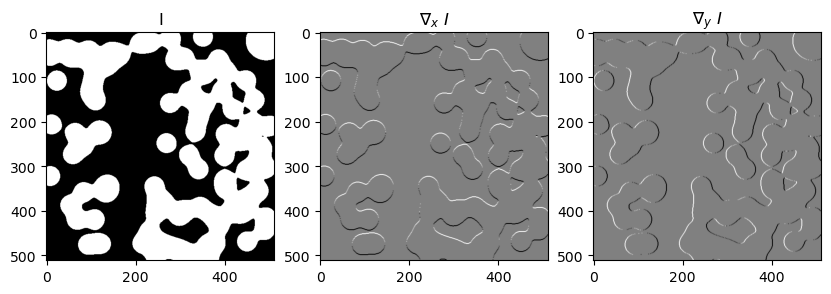

In [13]:
fig = plt.figure(figsize=(10,8))
plt.subplot(1,3,1)
plt.imshow(I, cmap='gray')
plt.title('I')
plt.subplot(1,3,2)
plt.imshow(Gx, cmap='gray')
plt.title(r'$\nabla_x \ I$')
plt.subplot(1,3,3)
plt.imshow(Gy, cmap='gray')
plt.title(r'$\nabla_y \ I$')
plt.show()

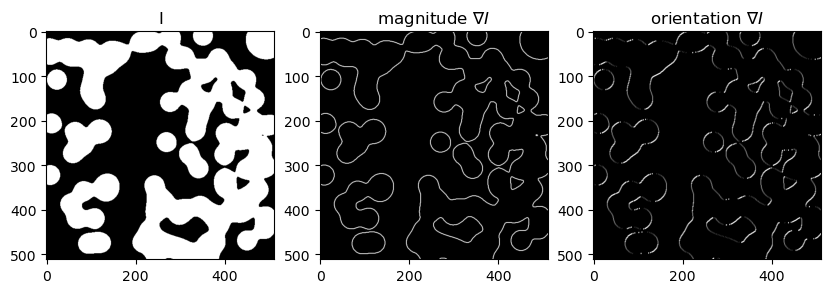

In [14]:
fig = plt.figure(figsize=(10,8))
plt.subplot(1,3,1)
plt.imshow(I, cmap='gray')
plt.title('I')
plt.subplot(1,3,2)
plt.imshow(magnitude, cmap='gray')
plt.title(r'magnitude $\nabla I$')
plt.subplot(1,3,3)
plt.imshow(angle, cmap='gray')
plt.title(r'orientation $\nabla I$')
plt.show()

In [15]:
Ixx = Gx**2
Iyy = Gy**2
Ixy = Gx*Gy

print(Ixx.shape, Iyy.shape, Ixy.shape)

(512, 512) (512, 512) (512, 512)


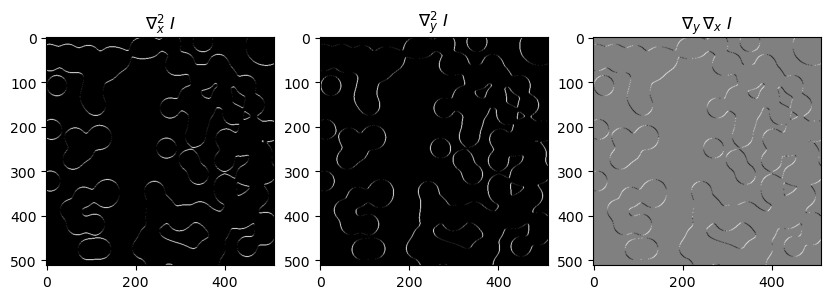

In [16]:
fig = plt.figure(figsize=(10,8))
plt.subplot(1,3,1)
plt.imshow(Ixx, cmap='gray')
plt.title(r'$\nabla_x^2 \ I$')
plt.subplot(1,3,2)
plt.imshow(Iyy, cmap='gray')
plt.title(r'$\nabla_y^2 \ I$')
plt.subplot(1,3,3)
plt.imshow(Ixy, cmap='gray')
plt.title(r'$\nabla_y \, \nabla_x \ I$')
plt.show()

In [17]:
k = 0.05

det = (Ixx*Iyy) - (Ixy*Ixy) 
H   = (Ixx*Iyy) - (Ixy*Ixy) - k*np.square(Ixx + Iyy) 

In [18]:
print(det.min(), det.max())

0.0 0.0


In [19]:
print(H.min(), H.max())

-20.0 0.0


In [20]:
Hnorm = H - H.min()
Hnorm = Hnorm / Hnorm.max()

In [21]:
print(Hnorm.min(), Hnorm.max())

0.0 1.0


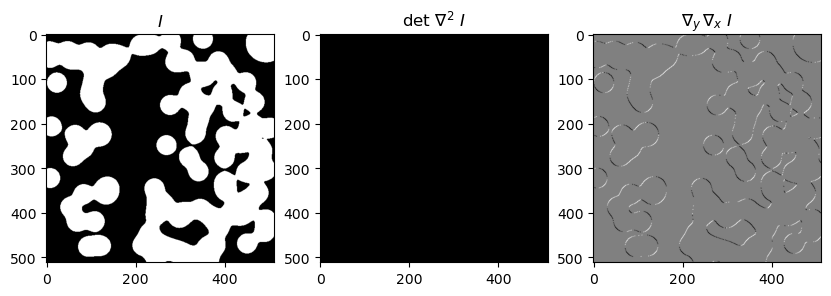

In [22]:
fig = plt.figure(figsize=(10,8))
plt.subplot(1,3,1)
plt.imshow(I, cmap='gray')
plt.title(r'$I$')
plt.subplot(1,3,2)
plt.imshow(det, cmap='gray')
plt.title(r'$\det \, \nabla^2 \ I$')
plt.subplot(1,3,3)
plt.imshow(Ixy, cmap='gray')
plt.title(r'$\nabla_y \, \nabla_x \ I$')
plt.show()

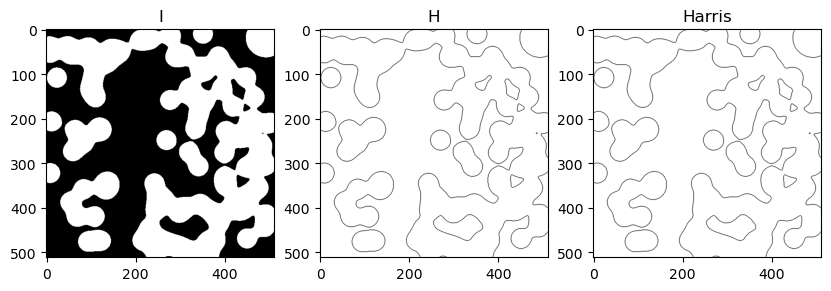

In [23]:
fig = plt.figure(figsize=(10,8))
plt.subplot(1,3,1)
plt.imshow(I, cmap='gray')
plt.title('I')
plt.subplot(1,3,2)
plt.imshow(H, cmap='gray')
plt.title('H')
plt.subplot(1,3,3)
plt.imshow(Hnorm, cmap='gray')
plt.title('Harris')
plt.show()

In [24]:
def corner_response(I, k, Sx, Sy, G, sz=1):
    
    # compute first derivatives
    padI = np.pad(I, pad_width=sz, mode='symmetric', reflect_type='even')
    dx  = correlate2d(padI, Sx, mode='valid')
    dy  = correlate2d(padI, Sy, mode='valid')
    
    dxdx = np.pad(dx*dx, pad_width=sz, mode='symmetric', reflect_type='even')
    dydy = np.pad(dy*dy, pad_width=sz, mode='symmetric', reflect_type='even')
    dxdy = np.pad(dx*dy, pad_width=sz, mode='symmetric', reflect_type='even')
    
    Ixx = correlate2d(dxdx, G, mode='valid')
    Iyy = correlate2d(dydy, G, mode='valid')
    Ixy = correlate2d(dxdy, G, mode='valid')
    
    # compute corner response at all pixels
    R = (Ixx*Iyy - (Ixy*Ixy)) - k*((Ixx + Iyy)**2)
    return R

In [25]:
# hyperparameters
k = 0.08
thresh = 0.9

# compute response
response = corner_response(J, k, hx, hy, g, sz=1)

# thresholded corner responses
strong_corners = (response > thresh)

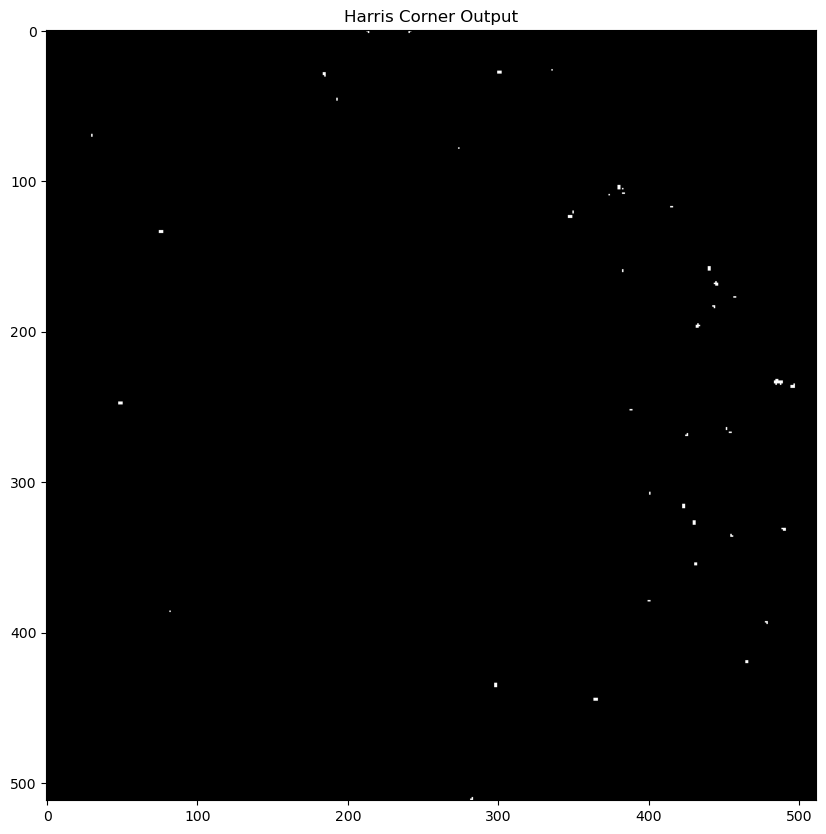

In [26]:
plt.figure(figsize=(10,10))
plt.imshow(strong_corners, cmap='gray')
plt.title("Harris Corner Output")
plt.show()

In [27]:
coords = np.argwhere(strong_corners == 1)
coords.shape

(163, 2)

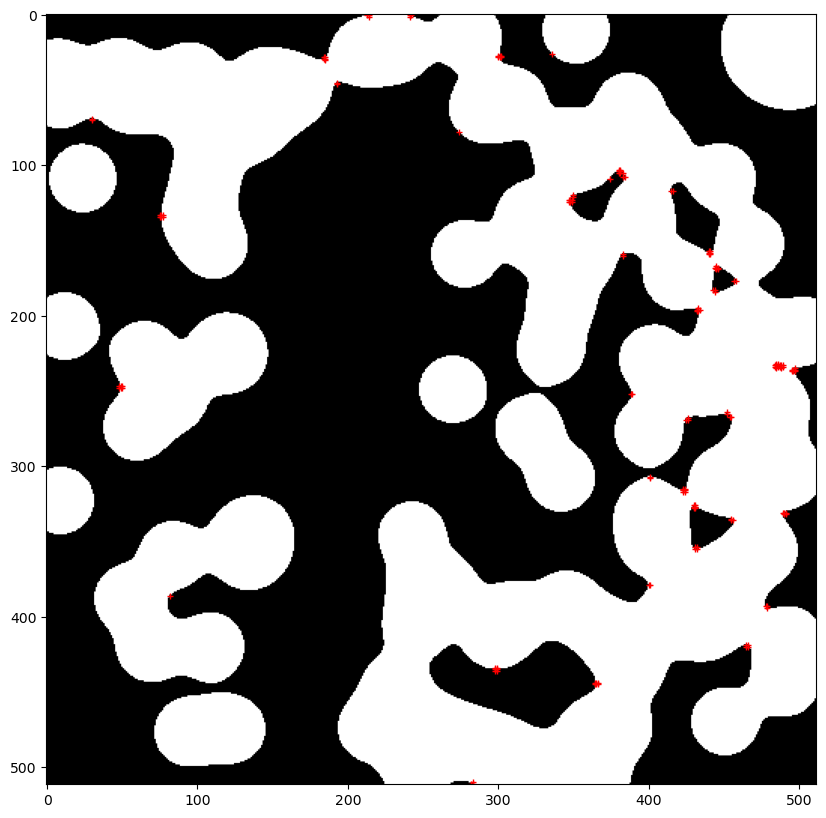

In [28]:
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(J, cmap=plt.cm.gray)
# plot corners
#ax.plot(coords[:, 1], coords[:, 0], color='cyan', marker='o', linestyle='None', markersize=6)
ax.plot(coords[:, 1], coords[:, 0], '+r', markersize=5, lw=1)
#ax.axis((0, 310, 200, 0))
plt.show()

# Harris detector in Scikit-Image

In [29]:
coords = corner_peaks(corner_harris(J), min_distance=5, threshold_rel=0.02)
coords_subpix = corner_subpix(J, coords, window_size=13)

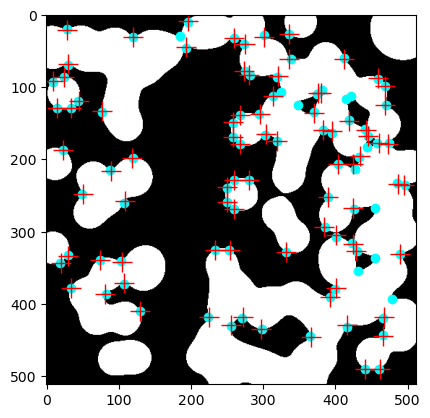

In [30]:
fig, ax = plt.subplots()
ax.imshow(J, cmap=plt.cm.gray)
ax.plot(coords[:, 1], coords[:, 0], color='cyan', marker='o',
        linestyle='None', markersize=6)
ax.plot(coords_subpix[:, 1], coords_subpix[:, 0], '+r', markersize=15)
plt.show()